# Paper Plot R2, Profile for different climates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  # , get_pressure
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
from neural_networks.cbrain.cam_constants import *
import matplotlib.pyplot as plt
import gc
import pickle
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cmocean
import seaborn as sns


2024-04-11 14:05:24.071052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [6]:
font_size = 13

In [7]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

In [14]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5
# training_109_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_train
# training_110_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_val
# training_111_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_train
# training_112_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_val

training_runs = {
    "plus4k": "training_103_mask_net_prediction_thresholds_spars0.001_plus4k",
    "minus4k": "training_104_mask_net_prediction_thresholds_spars0.001_minus4k",
    # "plus4k_ref": "training_105_mask_net_prediction_thresholds_spars0.001_plus4k_ref",
    # "minus4k_ref": "training_106_mask_net_prediction_thresholds_spars0.001_minus4k_ref",
    "plus4k_ref2": "training_109_mask_net_prediction_thresholds_spars0.001_plus4k_ref2_train",
    "minus4k_ref2": "training_111_mask_net_prediction_thresholds_spars0.001_minus4k_ref2_train",}

train_val = "_train"

outputs_list_file = os.path.join(PROJECT_ROOT, "output_castle", "training_103_mask_net_prediction_thresholds_spars0.001_plus4k", 
                                 "outputs_list.txt")
ANCIL_FILE = os.path.join(Path.cwd().parent.resolve(), "data", "ancil_spcam.nc")

In [15]:
def get_base_dir(d):
    return os.path.join(PROJECT_ROOT, "output_castle", d)

def get_plots_dir(d):
    return os.path.join(PROJECT_ROOT, "output_castle", d, "plots_offline_evaluation")

def get_cfg(d):
    return os.path.join(PROJECT_ROOT, "output_castle", d, f"cfg_mask_net_thresholds{train_val}.yml")
    

In [150]:
climate = "minus4k" # plus4k, minus4k
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [151]:
def get_profiles_dir():
    profiles_dirs = dict()
    
    for key in [climate]: #, climate + "_ref2"]:     
        plots_dir = get_plots_dir(training_runs[key])
        profile_dir = os.path.join(plots_dir, "plots_profiles" + train_val, 
                                   f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

        profiles_dirs[key] = profile_dir

    key = climate + "_ref2"
    plots_dir = get_plots_dir(training_runs[key])
    profile_dir = os.path.join(plots_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
    profiles_dirs[key] = profile_dir
    
    return profiles_dirs
        

In [152]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [153]:
profiles_dirs = get_profiles_dir()

In [154]:
profiles = {key: {} for key in profiles_dirs.keys()}

for key, pd in profiles_dirs.items():
    profiles[key]["truth"] = load_pickle(os.path.join(pd, f"{variable}_profile_truth.p"))
    profiles[key]["pred"] = load_pickle(os.path.join(pd, f"{variable}_profile_pred.p"))
    profiles[key][stats] = load_pickle(os.path.join(pd, f"{variable}_stats-{stats}.p"))

In [155]:
def parse_label(l): 
    if l == "plus4k":
        return "+4K"
    elif l == "plus4k_ref":
        return "+4K ref" 
    elif l == "minus4k":
        return "-4K" 
    elif l == "minus4k_ref":
        return "-4K ref" 
    elif l == "plus4k_ref2":
        return "+4K ref" 
    elif l == "minus4k_ref2":
        return "-4K ref" 
    else: 
        raise ValueError(f"Cannot parse unknown label {l}")

In [156]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [157]:
outputs_list = parse_txt_to_list(outputs_list_file)

In [158]:

def plot_profile_r2(ax1, which_ref): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"
    orange = '#cc5500'

    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    keys = [climate, climate + "_ref2"]

    vmin = np.min([np.min(profiles[k][p]) for p in ["truth", "pred"] for k in keys])
    vmax = np.max([np.max(profiles[k][p]) for p in ["truth", "pred"] for k in keys])
        
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    line_truth, = ax1.plot(np.mean(profiles[climate]["truth"], axis=0), P, 
                             label=f"{parse_label(climate)} SPCAM", color=blue)
    
    line_pred_1, = ax1.plot(np.mean(profiles[climate]["pred"], axis=0), P, 
                            label=f"{parse_label(climate)} Prediction", linestyle="dashed", color=blue)
    line_pred_2, = ax1.plot(np.mean(profiles[climate + which_ref]["pred"], axis=0), P, 
                            label=f"{parse_label(climate + which_ref)} Prediction", linestyle="dotted", color=blue)
    
    ax1.set_xlim(vmin, vmax)
    
    ax1.tick_params(bottom=True, left=True, length=2)
    ax1.tick_params(axis='x', labelsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)

    ax1.set_yticks([200, 400, 600, 800])

    ax1.set_xlabel(f'{var_label[variable]} ({units[variable]})', color=blue)
    ax1.tick_params(axis='x', colors=blue) 
    
    ax1.set_ylabel('Pressure (hPa)')
    
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300])
    
    # Create a secondary X-axis (top)
    ax2 = ax1.twiny()  # Share the same Y-axis
    
    arr_1 = np.mean(profiles[climate][stats], axis=1)
    arr_2 = np.mean(profiles[climate + which_ref][stats], axis=1)

    if variable == "phq": 

        # last_neg_index = np.max([np.where(arr_1 < 0)[0][-1], np.where(arr_2 < 0)[0][-1]])
        # last_neg_index -= 1

        last_neg_index = 10 # start with 168
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        label = r"{} $R^2$".format(parse_label(climate))
        line_r2_1, = ax2.plot(arr_1[last_neg_index+1:], P[last_neg_index + 1:], 
                          label=label, linestyle="dashed", color=red)  
        label = r"{} $R^2$".format(parse_label(climate + which_ref))
        line_r2_2, = ax2.plot(arr_2[last_neg_index+1:], P[last_neg_index + 1:], 
                          label=label, linestyle="dotted", color=red)  

    else:     
        label = r"{} $R^2$".format(parse_label(climate))
        line_r2_1, = ax2.plot(arr_1, P, 
                              label=label, linestyle="dashed", color=red)  
        label = r"{} $R^2$".format(parse_label(climate + which_ref))
        line_r2_2, = ax2.plot(arr_2, P, 
                              label=label, linestyle="dotted", color=red)  
        

    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score', color=red)
    ax2.tick_params(axis='x', colors=red)  # Set color of ticks and labels to red
    
    ax2.spines['top'].set_color(red)  
    ax2.spines['bottom'].set_color(blue)
    
    ax1.set_ylabel('Pressure (hPa)', labelpad=15, color='#333333')
    ax1.set_xlabel(f"{variable} ({units[variable]})", labelpad=15, color='#333333')
    
    ax1.set_rasterized(True)
    ax2.set_rasterized(True)
    
    plt.legend(handles=[line_truth, line_pred_1, line_pred_2, line_r2_1, line_r2_2], 
               prop={'size': 12}, loc="center left")



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_104_mask_net_prediction_thresholds_spars0.001_minus4k/plots_offline_evaluation/plots_paper_train/tphystnd_profile_r2_minus4k_ref2.pdf


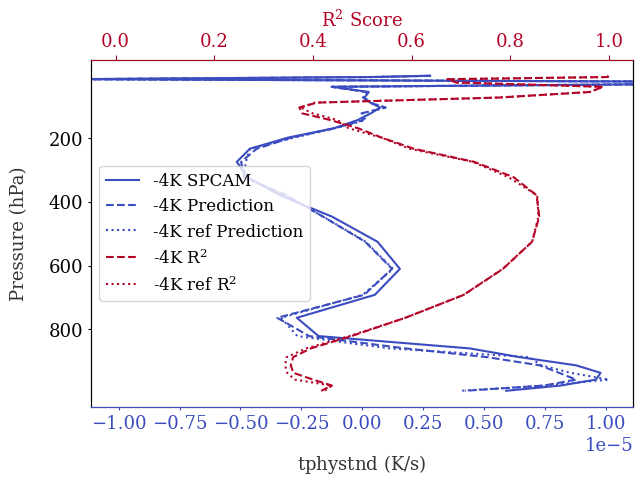

In [159]:
plt.close()

which_ref = "_ref2" # _ref, _ref2

fig, ax1 = plt.subplots(figsize=(7, 4.5))
plot_profile_r2(ax1, which_ref)

output_dir = os.path.join(get_plots_dir(training_runs[climate]), "plots_paper" + train_val)
Path(output_dir).mkdir(parents=True, exist_ok=True)

# 168
# f_path = os.path.join(output_dir, f"{variable}_profile_r2_{climate}{which_ref}_cutoff_168.pdf") 
f_path = os.path.join(output_dir, f"{variable}_profile_r2_{climate}{which_ref}.pdf")

fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()